In [1]:
#!pip install pytorch-lightning
#!pip install --upgrade pip && pip3 install h5py=='2.9.0'

In [2]:
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import tqdm 


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
df = pd.read_csv('Full_Sim_1M.csv')
df_neutrons = df[df[' pdg'].isin([2112])]
df_photons  = df[df[' pdg'].isin([22])]

In [5]:
param_list = [" xx"," yy"," pxx"," pyy"," pzz"," eneg"," time"," pdg"]

df_N = df_neutrons.loc[:,param_list]
df_P = df_photons.loc[:,param_list]
torch_tensor = torch.tensor(df_N[param_list].values)

N_data = TensorDataset(torch_tensor,torch.ones(len(torch_tensor)))


In [6]:
def plot_correlations(x,y,bins=[200,200],loglog=False):
  
  H,xb,yb = np.histogram2d(x,y,bins=bins,range=[[x.min(), x.max()], [y.min(), y.max()]])
  X , Y = np.meshgrid(xb,yb)
  plt.pcolormesh(X,Y,np.log10(H.T))
  if loglog:
    plt.xscale('log')
    plt.yscale('log')
  plt.colorbar()
  plt.show()


In [7]:
def plots(df):
  plot_correlations(df[' xx'],df[' yy'])
  Ebin = 10**np.linspace(np.log10(df[' eneg'].min()), np.log10(df[' eneg'].max()),200)
  Tbin = 10**np.linspace(np.log10(df[' time'].min()), np.log10(df[' time'].max()),200)
  plot_correlations(df[' time'],df[' eneg'] ,bins = [Tbin,Ebin], loglog=True)
  plot_correlations(df['r'],df['theta'])

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_6189/45613613.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


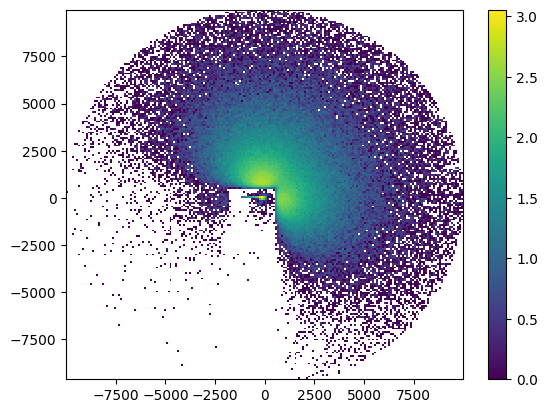

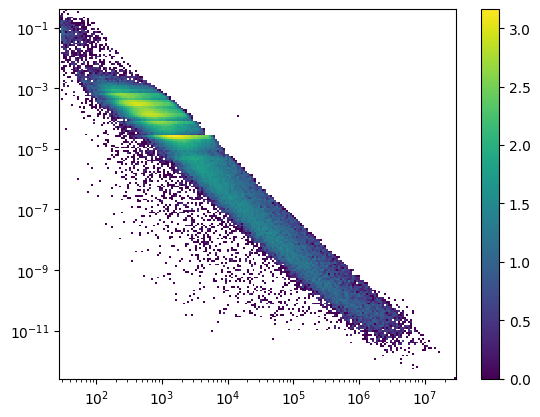

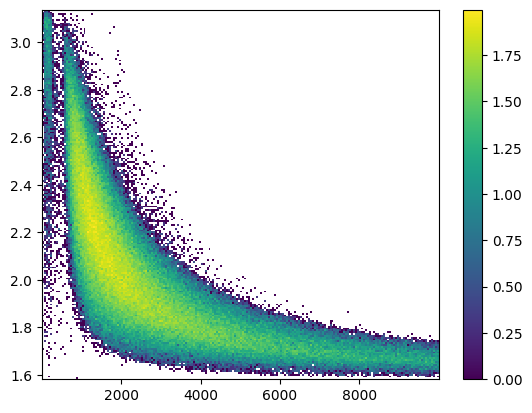

(230247, 10)


In [8]:
df_P['r'] = np.sqrt(df_P[' xx'].values**2 + df_P[' yy'].values**2)
df_N['r'] = np.sqrt(df_N[' xx'].values**2 + df_N[' yy'].values**2)
th_P = np.arccos(df_P[' pzz'].values/np.sqrt(df_P[' pxx'].values**2+df_P[' pyy'].values**2+df_P[' pzz'].values**2))
th_N = np.arccos(df_N[' pzz'].values/np.sqrt(df_N[' pxx'].values**2+df_N[' pyy'].values**2+df_N[' pzz'].values**2))
df_P['theta']=th_P
df_N['theta']=th_N
plots(df_N)
print(df_N.shape)

In [33]:
N_T = torch.tensor(df_N.values)
P_T = torch.tensor(df_P.values)
l = [0,1,2,3,4,5,6,8,9]
N_T = N_T[:,l]
P_T = P_T[:,l]
# x , y , p , E , t , pdg , r , theta
P_T.shape
plt.hist(N_T[:,5],bins=np.logspace(torch.log(torch.min(N_T[:,5]),torch.max(N_T[:,5]))))
plt.loglog()
plt.figure()
plt.hist(N_T[:,6],bins=np.logspace(torch.log(torch.min(N_T[:,6]),torch.max(N_T[:,6]))))
plt.loglog()
plt.show()

TypeError: min() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


In [10]:
def weights_init(m):
    if isinstance(m,nn.Linear):
        nn.init.normal_(m.weight.data, 0.01,0.02)
        print('initialized')

In [11]:
class ParticleDataset(Dataset):
  def __init__(self, data_path, norm_path):
    super().__init__()
    self.data = pd.read_csv(data_path)
    self.data = self.data[self.data[' pdg'].isin([2112])]  # 22 - photons , 2112 - neutrons
    self.data = self.data[[" xx"," yy"," pxx"," pyy"," pzz"," eneg"," time"]]
    # self.data['r'] = np.sqrt(self.data[' xx'].values**2 + self.data[' yy'].values**2)
    # self.data['theta'] = np.arccos(self.data[' pzz'].values/np.sqrt(self.data[' pxx'].values**2+self.data[' pyy'].values**2+self.data[' pzz'].values**2))
    self.norm = pd.read_csv(norm_path, index_col=0)
    for col in self.norm.index:
        self.data[col] = (self.data[col] - self.norm.loc[col]['mean'])/self.norm.loc[col]['std']
    self.data = self.data.values
    self.data = self.data.astype(np.float32)
  def __getitem__(self, item):
    return self.data[item, :]
  def __len__(self):
    return self.data.shape[0]

In [12]:
dataset = ParticleDataset('Full_Sim_1M.csv', 'Full_Sim_1M_stats.csv')
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

In [13]:
class Generator(nn.Module):
    def __init__(self):
      super().__init__()
      
      N_z = 20
        
      self.main = nn.Sequential(
        nn.Linear(N_z,25),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,25),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,25),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,9),
        nn.ReLU(),
        nn.Linear(9,7)
      )
    def forward(self, input):
      return self.main(input)
      

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
      super().__init__()
        
      self.main = nn.Sequential(
        nn.Linear(7,25),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,25),
        nn.ReLU(),
        nn.Linear(25,10),
        nn.ReLU(),
        nn.Linear(10,1),
        nn.Sigmoid()
      )
    def forward(self, input):
      return self.main(input)
    

In [15]:
mps_device = torch.device('mps')

net_G = Generator().to(mps_device)
net_D = Discriminator().to(mps_device)

print(net_G,net_D)

Generator(
  (main): Sequential(
    (0): Linear(in_features=20, out_features=25, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=25, out_features=25, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=25, out_features=25, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=25, out_features=9, bias=True)
    (10): ReLU()
    (11): Linear(in_features=9, out_features=7, bias=True)
  )
) Discriminator(
  (main): Sequential(
    (0): Linear(in_features=7, out_features=25, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=25, out_features=25, bias=True)
    (4): ReLU()
    (5): Linear(in_features=25, out_features=10, bias=

In [16]:
loss_func = nn.BCELoss()
N_z = 20
noise = torch.randn(256, N_z, device = mps_device)
real_label = 1
fake_label = 0
optimizer_G = optim.Adam(net_G.parameters(), lr = 0.0001, betas= (0.5,0.999))
optimizer_D = optim.Adam(net_D.parameters(), lr = 0.0001, betas= (0.5,0.999))

In [24]:
# Lists to keep track of progress

G_losses = []
D_losses = []
iters = 0
num_epochs = 100
net_G.to(mps_device)
net_G.apply(weights_init)
net_D.apply(weights_init)

print("Starting Training Loop...")

for epoch in tqdm.tqdm_notebook(range(num_epochs), desc=' epochs', position=0):

    avg_error_G, avg_error_D = 0, 0
    avg_Dx, avg_DGz1, avg_DGz2 = 0., 0., 0.

    for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):

        # Update the discriminator network

        ## Train with all-real batch
        net_D.zero_grad()
        
        real_data = data.to(mps_device)
        b_size = len(data)
        label = torch.full((b_size,), real_label, device=mps_device).float()
        
        output = net_D(real_data).view(-1)

        err_D_real = loss_func(output, label)
        err_D_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, N_z, device=mps_device)
        fake_p = net_G(noise)

        label.fill_(fake_label)
        output = net_D(fake_p.detach()).view(-1)

        err_D_fake = loss_func(output, label)
        err_D_fake.backward()
        
        err_D = err_D_real + err_D_fake

        # update the discriminator network
        optimizer_D.step()

        # Update the Generator network: maximize log(D(G(z)))
        net_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        output = net_D(fake_p).view(-1)
        err_G = loss_func(output, label)
        err_G.backward()
        
        #for name, param in net_G.named_parameters():
        #    print(name, param)
        #    continue
        
        # update the generator network
        optimizer_G.step()
        
        # computing the average losses and discriminator
        avg_error_G += err_G.item()
        avg_error_D += err_D.item()

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = net_G(noise).detach().cpu()
            # plot correlations of x-y E-t r-theta

        iters += 1

    avg_error_G = avg_error_G/len(dataloader.dataset)
    avg_error_D = avg_error_D/len(dataloader.dataset)
    if len(G_losses)>0:
        if avg_error_G<G_losses[-1]:
            torch.save(net_G.state_dict(), 'saved_Gen.pt')
    G_losses.append(avg_error_G)
    D_losses.append(avg_error_D)
    print(f'{epoch}/{num_epochs}\tLoss_D: {avg_error_D:.4f}\tLoss_G: {avg_error_G:.4f}')

initialized
initialized
initialized
initialized
initialized
initialized
initialized
initialized
initialized
Starting Training Loop...


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_6189/1915898212.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs), desc=' epochs', position=0):


 epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_6189/1915898212.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

0/100	Loss_D: 0.0183	Loss_G: 0.0161


 batch: 0it [00:00, ?it/s]

1/100	Loss_D: 0.0049	Loss_G: 0.0217


 batch: 0it [00:00, ?it/s]

2/100	Loss_D: 0.0029	Loss_G: 0.0433


 batch: 0it [00:00, ?it/s]

3/100	Loss_D: 0.0117	Loss_G: 0.0280


 batch: 0it [00:00, ?it/s]

4/100	Loss_D: 0.0184	Loss_G: 0.0160


 batch: 0it [00:00, ?it/s]

5/100	Loss_D: 0.0188	Loss_G: 0.0148


 batch: 0it [00:00, ?it/s]

6/100	Loss_D: 0.0195	Loss_G: 0.0139


 batch: 0it [00:00, ?it/s]

7/100	Loss_D: 0.0186	Loss_G: 0.0144


 batch: 0it [00:00, ?it/s]

8/100	Loss_D: 0.0175	Loss_G: 0.0161


 batch: 0it [00:00, ?it/s]

9/100	Loss_D: 0.0163	Loss_G: 0.0188


 batch: 0it [00:00, ?it/s]

10/100	Loss_D: 0.0148	Loss_G: 0.0200


 batch: 0it [00:00, ?it/s]

11/100	Loss_D: 0.0141	Loss_G: 0.0215


 batch: 0it [00:00, ?it/s]

12/100	Loss_D: 0.0145	Loss_G: 0.0224


 batch: 0it [00:00, ?it/s]

13/100	Loss_D: 0.0141	Loss_G: 0.0225


 batch: 0it [00:00, ?it/s]

14/100	Loss_D: 0.0124	Loss_G: 0.0241


 batch: 0it [00:00, ?it/s]

15/100	Loss_D: 0.0114	Loss_G: 0.0271


 batch: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [20]:
classname = net_G.__class__.__name__
if classname.find('Linear') == -1: print("found")

found


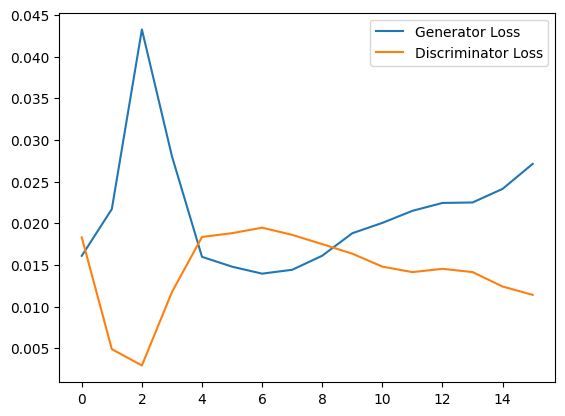

In [26]:
plt.plot(G_losses)
plt.plot(D_losses)

plt.legend(["Generator Loss","Discriminator Loss"])

In [28]:
noise = torch.randn(230247, N_z, device='cpu')
net_G.to('cpu')
fake_p = net_G(noise).detach().numpy()

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_6189/45613613.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


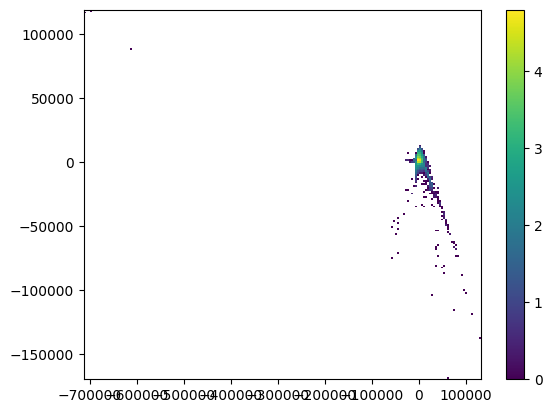

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_6189/649117360.py:3: RuntimeWarning: invalid value encountered in log10
  Ebin = 10**np.linspace(np.log10(df[' eneg'].min()), np.log10(df[' eneg'].max()),200)
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_6189/649117360.py:4: RuntimeWarning: invalid value encountered in log10
  Tbin = 10**np.linspace(np.log10(df[' time'].min()), np.log10(df[' time'].max()),200)


ValueError: invalid entry in coordinates array

In [29]:
generated_df = df_N.copy()

for i in range(len(param_list)-1):
    mean = dataset.norm.loc[param_list[i]]['mean']
    std =  dataset.norm.loc[param_list[i]]['std']
    generated_df[param_list[i]]=fake_p[:,i]*std+mean*np.ones(len(fake_p[:,i]))

generated_df['r']=np.sqrt(generated_df[' xx']**2+generated_df[' yy']**2)
th_g = np.arccos(generated_df[' pzz'].values/np.sqrt(generated_df[' pxx'].values**2+generated_df[' pyy'].values**2+generated_df[' pzz'].values**2))
generated_df['theta']=th_g
plots(generated_df)
plots(df_N)